In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [242]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [243]:
class autoencoder(nn.Module):
    def __init__(self,input_dim=28, out_dim=2):
        super(autoencoder,self).__init__()
        
        self.encoder= nn.Sequential(
                nn.Conv2d(1,32,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32,64,3),
                nn.LeakyReLU(),
                
                nn.BatchNorm2d(64),
                nn.Conv2d(64,64,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(64),
                nn.Conv2d(64,64,3),
                nn.LeakyReLU(),
                nn.BatchNorm2d(64))
        self.fc1= nn.Linear(64*20*20,2)
        
        self.decoder = nn.Sequential(
                    nn.Linear(2,64*20*20),
                    nn.Unflatten(1,(64,20,20)),
                    nn.ConvTranspose2d(64,64,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64,64,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(64),
                    nn.ConvTranspose2d(64,32,3),
                    nn.LeakyReLU(),
                    nn.BatchNorm2d(32),
                    nn.ConvTranspose2d(32,1,3),
                    nn.Sigmoid()
                    )
        
        
    def forward(self,x):
        x= self.encoder(x)
        #print(x.shape)
        encoded = self.fc1(torch.flatten(x,1))
        #print(encoded.shape)
        decoded= self.decoder(encoded)
        return decoded
        
        
        
        

In [257]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

In [245]:
trainloader

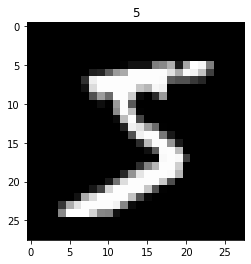

In [294]:
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0], cmap='gray')
plt.title('%i' % trainset.targets[0])
plt.show()

In [247]:
model= autoencoder(28,2).to(device)

In [248]:
optimizer= optim.Adam(model.parameters(),lr=1e-5)

In [249]:
criterion= nn.MSELoss()

In [251]:
for epoch in range(100):
    size = len(trainloader.dataset)
    for batch,(x,Y) in enumerate(trainloader):
        x_train,y_train= x.to(device),x.to(device)
        y_pred= model(x_train)
        loss= criterion(y_pred,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 1000==0:
            loss, current = loss.item(), batch * len(x_train)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",f"epoch: {epoch}")
    

loss: 1.177522  [    0/60000] epoch: 0
loss: 1.163184  [32000/60000] epoch: 0
loss: 1.170238  [    0/60000] epoch: 1
loss: 1.153191  [32000/60000] epoch: 1
loss: 1.158342  [    0/60000] epoch: 2
loss: 1.151404  [32000/60000] epoch: 2
loss: 1.128518  [    0/60000] epoch: 3
loss: 1.156202  [32000/60000] epoch: 3
loss: 1.118426  [    0/60000] epoch: 4
loss: 1.141308  [32000/60000] epoch: 4
loss: 1.152459  [    0/60000] epoch: 5
loss: 1.153661  [32000/60000] epoch: 5
loss: 1.127699  [    0/60000] epoch: 6
loss: 1.151295  [32000/60000] epoch: 6
loss: 1.132468  [    0/60000] epoch: 7
loss: 1.140651  [32000/60000] epoch: 7
loss: 1.153661  [    0/60000] epoch: 8
loss: 1.181884  [32000/60000] epoch: 8
loss: 1.141767  [    0/60000] epoch: 9
loss: 1.155308  [32000/60000] epoch: 9
loss: 1.134217  [    0/60000] epoch: 10
loss: 1.134814  [32000/60000] epoch: 10
loss: 1.137814  [    0/60000] epoch: 11
loss: 1.095052  [32000/60000] epoch: 11
loss: 0.955652  [    0/60000] epoch: 12
loss: 0.918203  [320

KeyboardInterrupt: 

In [255]:
torch.save(model.state_dict(), "autoencoder.pt")

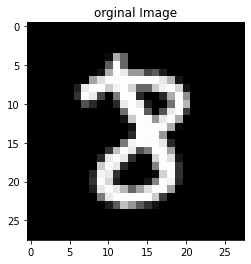

In [323]:
for batch,(x,Y) in enumerate(testloader):
    item = x.reshape(-1, 28, 28)
    reconstructed= model(x.to(device))
    generate= reconstructed.cpu()
    plt.imshow(item[0],cmap='gray')
    plt.title("orginal Image")
    

Text(0.5, 1.0, 'generated image')

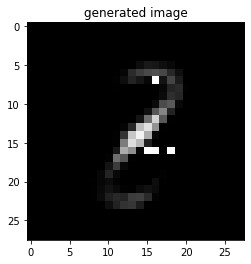

In [324]:
plt.imshow(generate.data[0].squeeze(),cmap='gray')
plt.title('generated image')

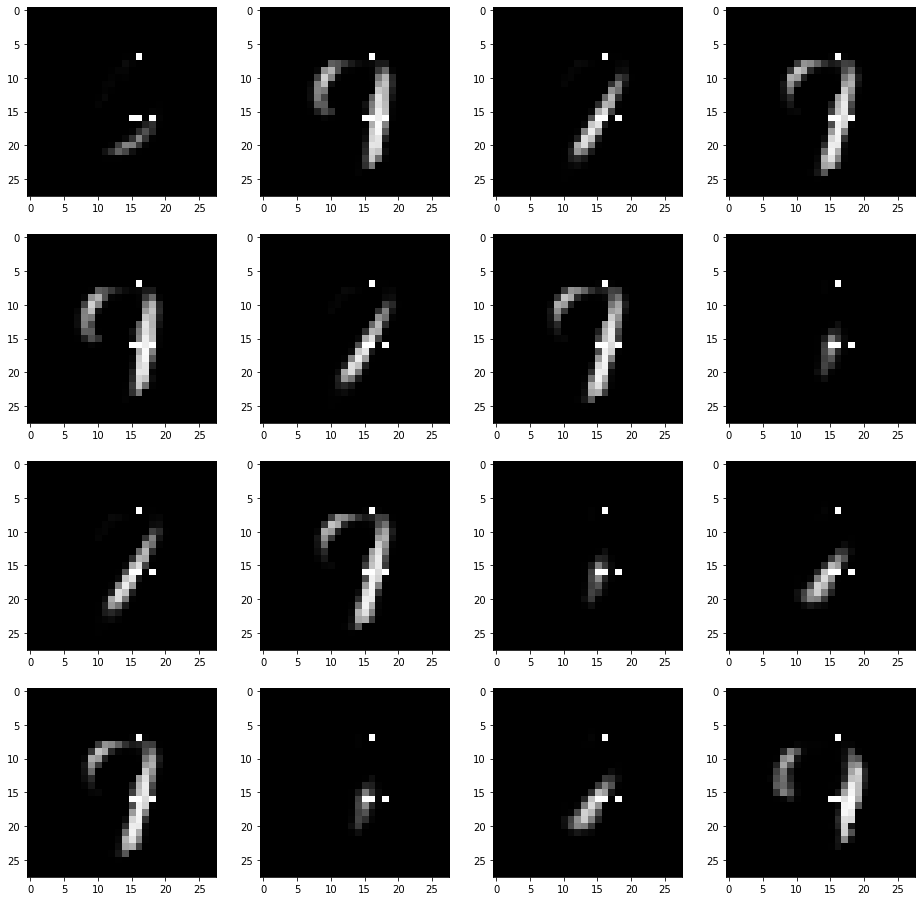

In [321]:
fig,axs = plt.subplots(4,4,figsize=(16, 16))
for i in range(4):
    for j in range(4):
        img = generate.data[j].squeeze()
        axs[i][j].imshow(img,cmap='gray')